In [1]:
import numpy as np
from itertools import product
from numpy.random import default_rng

# -----------------------------------------
# Build bitstrings + bit arrays for 8 qubits
# -----------------------------------------
def bitstrings(n_qubits=8):
    bs = [''.join(bits) for bits in product("01", repeat=n_qubits)]
    arr = np.array([[int(b) for b in s] for s in bs], dtype=int)
    return bs, arr

BS, BS_bits = bitstrings(8)
weight4_mask = (BS_bits.sum(axis=1) == 4)

# -----------------------------------------
# Project vector onto the probability simplex
# -----------------------------------------
def project_probability_simplex(x):
    v = np.array(x, dtype=float)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(v)+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0.0)

# -----------------------------------------
# Kronecker-build full confusion matrix
# per_qubit_probs has shape (8,2,2)
# -----------------------------------------
def build_confusion_matrix_from_perqubit(per_qubit_probs):
    C = per_qubit_probs[0]
    for q in range(1, per_qubit_probs.shape[0]):
        C = np.kron(C, per_qubit_probs[q])
    return C

# -----------------------------------------
# Compute the final observable combination
# -----------------------------------------
def compute_cov_expression(p, BS_bits, idx):
    i, j, pidx, q = idx
    b = BS_bits
    ni, nj = b[:,i], b[:,j]
    np_, nq = b[:,pidx], b[:,q]

    Ei = (p * ni).sum()
    Ej = (p * nj).sum()
    Ep = (p * np_).sum()
    Eq = (p * nq).sum()

    Eip = (p * (ni*np_)).sum()
    Eiq = (p * (ni*nq)).sum()
    Ejp = (p * (nj*np_)).sum()
    Ejq = (p * (nj*nq)).sum()

    cov_ip = Eip - Ei*Ep
    cov_iq = Eiq - Ei*Eq
    cov_jp = Ejp - Ej*Ep
    cov_jq = Ejq - Ej*Eq

    return cov_ip - cov_iq - cov_jp + cov_jq


In [ ]:
def bootstrap_covariance(
        counts,
        times,
        beamsplitter_time,
        beamsplitter_time_err,
        calib_counts_per_qubit,
        pair_indices=(0,1,2,3),
        B=1000,
        sample_calibration=False,
        seed=123):

    rng = np.random.default_rng(seed)
    T = counts.shape[1]
    N = counts[:,0].sum()
    meas_pmfs = counts / counts.sum(axis=0)

    # Extract per-qubit maximum likelihood confusion matrices
    perq_ML = np.zeros_like(calib_counts_per_qubit, dtype=float)
    for q in range(8):
        for prep in [0,1]:
            row = calib_counts_per_qubit[q, :, prep]
            perq_ML[q, :, prep] = row/row.sum()

    # Rebuild full confusion matrix
    C = build_confusion_matrix_from_perqubit(perq_ML)
    try:
        Cinv = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        Cinv = np.linalg.pinv(C, rcond=1e-6)

    # Allocate storage
    S_all_t  = np.zeros((B, T))
    S_at_tb  = np.zeros(B)
    tb_samples = np.zeros(B)

    for b in range(B):
        # Optionally resample calibration
        if sample_calibration:
            alpha = 1.0
            perq = np.zeros_like(perq_ML)
            for q in range(8):
                perq[q,0] = rng.dirichlet(alpha + calib_counts_per_qubit[q,0])
                perq[q,1] = rng.dirichlet(alpha + calib_counts_per_qubit[q,1])

            # Rebuild full confusion matrix
            C = build_confusion_matrix_from_perqubit(perq)
            try:
                Cinv = np.linalg.inv(C)
            except np.linalg.LinAlgError:
                Cinv = np.linalg.pinv(C, rcond=1e-6)
                
        else:
            perq = perq_ML.copy()

        

        # Bootstrap each time slice
        for t in range(T):
            pmf = meas_pmfs[:,t]
            boot_counts = rng.multinomial(N, pmf)
            p_meas = boot_counts / N

            # Correct readout
            p_raw = Cinv @ p_meas
            p_raw = project_probability_simplex(p_raw)

            # Postselect weight-4
            p_raw[~weight4_mask] = 0
            if p_raw.sum() == 0:
                S_all_t[b,t] = 0
            else:
                p_post = p_raw / p_raw.sum()
                S_all_t[b,t] = compute_cov_expression(p_post, BS_bits, pair_indices)

        # Sample beamsplitter time
        tb = rng.normal(beamsplitter_time, beamsplitter_time_err)
        tb = np.clip(tb, times.min(), times.max())
        idx = np.argmin(np.abs(times - tb))
        S_at_tb[b] = S_all_t[b, idx]
        tb_samples[b] = tb

    # Compute pointwise statistics
    mean_S_t = S_all_t.mean(axis=0)
    std_S_t  = S_all_t.std(axis=0)
    ci16_S_t = np.percentile(S_all_t, 16, axis=0)
    ci84_S_t = np.percentile(S_all_t, 84, axis=0)

    # Beamsplitter point statistics
    mean_S_tb = S_at_tb.mean()
    std_S_tb  = S_at_tb.std()
    ci16_S_tb = np.percentile(S_at_tb, 16)
    ci84_S_tb = np.percentile(S_at_tb, 84)

    return {
        "S_all_t": S_all_t,
        "S_mean_t": mean_S_t,
        "S_std_t": std_S_t,
        "S_ci16_t": ci16_S_t,
        "S_ci84_t": ci84_S_t,
        "S_at_tb": S_at_tb,
        "S_mean_tb": mean_S_tb,
        "S_std_tb": std_S_tb,
        "S_ci16_tb": ci16_S_tb,
        "S_ci84_tb": ci84_S_tb,
        "tb_samples": tb_samples
    }


In [3]:
def run_both_bootstraps(
        counts,
        times,
        beamsplitter_time,
        beamsplitter_time_err,
        calib_counts_per_qubit,
        pair_indices=(0,1,2,3),
        B=1000):

    # Bootstrap A: *no* calibration sampling
    result_A = bootstrap_covariance(
        counts,
        times,
        beamsplitter_time,
        beamsplitter_time_err,
        calib_counts_per_qubit,
        pair_indices=pair_indices,
        B=B,
        sample_calibration=False,
        seed=1
    )

    # Bootstrap B: *with* calibration sampling
    result_B = bootstrap_covariance(
        counts,
        times,
        beamsplitter_time,
        beamsplitter_time_err,
        calib_counts_per_qubit,
        pair_indices=pair_indices,
        B=B,
        sample_calibration=True,
        seed=2
    )

    return result_A, result_B


# 2. Error Bars from Data

### 2.1 Load Data

In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np


import h5py
from datetime import datetime
import sys
import os
import shutil
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")


import current_measurements.src.src_current_measurement
importlib.reload(current_measurements.src.src_current_measurement);
from current_measurements.src.src_current_measurement import CurrentMeasurementCalibration, generate_ramp_beamsplitter_correlations_filename



import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)
from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename


In [7]:
config_filename = 'current_correlations_config.json'

with open(config_filename, 'r') as f:
    config = json.load(f)

coupling_point = 'coupling_point_2'


coupling_point_config = config[coupling_point]


In [8]:


correlation_pairs = []
for i in range(1, 8):
    for j in range(i + 2, 8):
        correlation_pairs.append(((i, i+1), (j,j+1)))



In [ ]:
# configuration_to_measurement = {}


In [10]:


for correlation_pair in correlation_pairs:
    date_code_dict = coupling_point_config['data_config'][str(correlation_pair)]

    year = date_code_dict['year']
    month = date_code_dict['month']
    day = str(date_code_dict['day'])
    hour = date_code_dict['hour']
    minute = date_code_dict['minute']
    second = date_code_dict['second']

    configuration = date_code_dict['configuration']

    filename = generate_ramp_beamsplitter_correlations_filename(year, month, day, hour, minute, second)

    if not configuration in configuration_to_measurement:
        configuration_to_measurement[configuration] = RampOscillationShotsMeasurement(filename)

### 2.2 Extract Error Bars

In [31]:
### single correlation

correlation_pair = ((1,2),(3,4))
correlation_pair = ((5,6),(7,8))

measurement = configuration_to_measurement[configuration]

counts = measurement.get_counts()
times = measurement.get_times()

beamsplitter_time = coupling_point_config['data_config'][str(correlation_pair)]['beamsplitter_time'] # ns
beamsplitter_time_err = 1 # ns # guess

confusion_matrices = measurement.get_confusion_matrices()
single_shot_calibration_counts = 5000
confusion_counts = (confusion_matrices * single_shot_calibration_counts).astype(int)

In [36]:

pair_indices = [x - 1 for x in correlation_pair[0] + correlation_pair[1]]

results = bootstrap_covariance(
    counts,
    times,
    beamsplitter_time,
    beamsplitter_time_err,
    confusion_counts,
    pair_indices=pair_indices,
    B=2000,
    sample_calibration=False
)

# Access beamsplitter point
S_tb_mean = results["S_mean_tb"]
S_tb_std  = results["S_std_tb"]
S_tb_ci16 = results["S_ci16_tb"]
S_tb_ci84 = results["S_ci84_tb"]

print(f"Beamsplitter S = {S_tb_mean:.4f} ± {S_tb_std:.4f}")
print(f"68% CI: [{S_tb_ci16:.4f}, {S_tb_ci84:.4f}]")

# Access pointwise timesteps
S_mean = results["S_mean_t"]
S_std  = results["S_std_t"]
S_ci16 = results["S_ci16_t"]
S_ci84 = results["S_ci84_t"]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

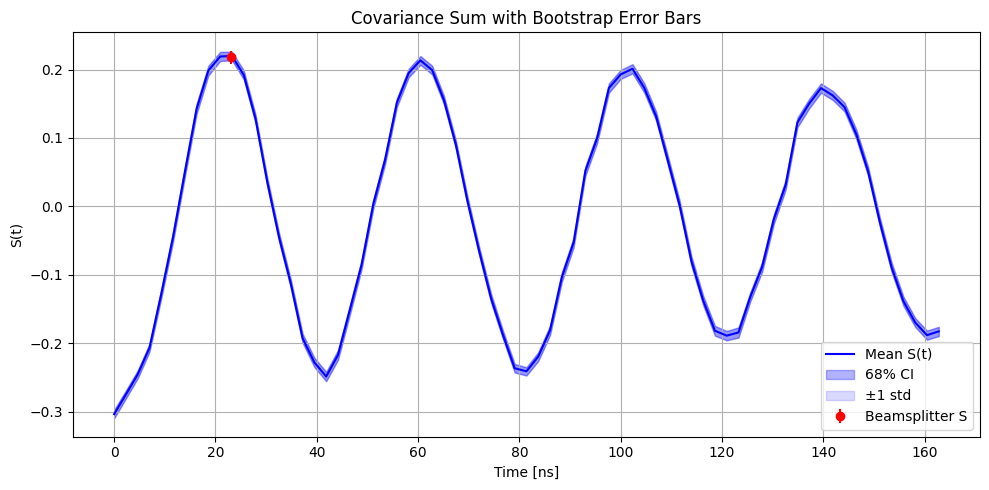

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

# Plot mean S(t)
plt.plot(times, S_mean, color='blue', label='Mean S(t)')

# Shaded 68% confidence interval
plt.fill_between(times, S_ci16, S_ci84, color='blue', alpha=0.3, label='68% CI')

# Optional: plot ±1 std deviation as lighter shade
plt.fill_between(times, S_mean-S_std, S_mean+S_std, color='blue', alpha=0.15, label='±1 std')

# Highlight the beamsplitter point
plt.errorbar(beamsplitter_time, S_tb_mean, yerr=S_tb_std, fmt='o', color='red', label='Beamsplitter S')

plt.xlabel('Time [ns]')
plt.ylabel('S(t)')
plt.title('Covariance Sum with Bootstrap Error Bars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
